<small><i>This notebook was put together by [Jake Vanderplas](http://www.vanderplas.com) for PyCon 2014. Source and license info is on [GitHub](https://github.com/jakevdp/sklearn_pycon2014/).</i></small>

# Unsupervised Learning In-depth: PCA and K-Means

Here we'll briefly go into a bit of depth on some important unsupervised learning techniques: **Principal Component Analysis (PCA)** and **K-Means**.

By the end of this section you should

- be able to describe how PCA reduces dimensionality
- be able to describe how K Means defines clusters
- see how these can be applied to several interesting problems

In [2]:
import matplotlib.pyplot as plt
import numpy as np

## Principal Component Analysis

Principal Component Analysis is a very powerful unsupervised method for *dimensionality reduction* in data.  It's easiest to visualize by looking at a two-dimensional dataset:

(-2.7292712056271964,
 2.5702744393352615,
 -0.9326181575178751,
 1.004413830229183)

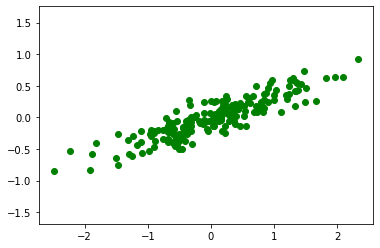

In [3]:
np.random.seed(1)
X = np.dot(np.random.random(size=(2, 2)), np.random.normal(size=(2, 200))).T
plt.plot(X[:, 0], X[:, 1], 'og')
plt.axis('equal')

We can see that there is a definite trend in the data. What PCA seeks to do is to find the **Principal Axes** in the data, and explain how important those axes are in describing the data distribution:

In [4]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X)
print(pca.explained_variance_)
print(pca.components_)

[0.7625315 0.0184779]
[[-0.94446029 -0.32862557]
 [-0.32862557  0.94446029]]


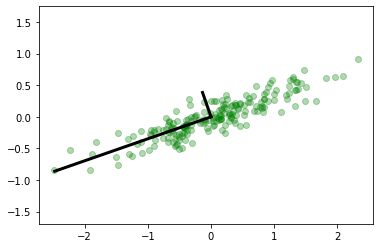

In [5]:
plt.plot(X[:, 0], X[:, 1], 'og', alpha=0.3)
plt.axis('equal')
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    plt.plot([0, v[0]], [0, v[1]], '-k', lw=3)

Notice that one direction is very important, while the other direction is not.  This shows us that the second principal component could be **completely ignored** without much loss of information! Let's see what our data look like if we only keep 95% of the variance:

In [9]:
clf = PCA(0.95)
X_trans = clf.fit_transform(X)
print(X.shape)
print(X_trans.shape)

(1797, 64)
(1797, 29)


By specifying that we want to throw away 5% of the variance, the data is now compressed by a factor of 50%! Let's see what the data look like after this compression:

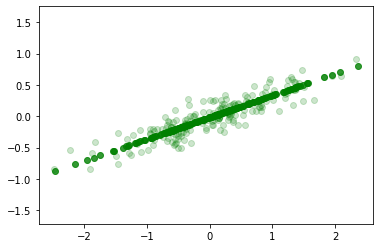

In [7]:
X_new = clf.inverse_transform(X_trans)
plt.plot(X[:, 0], X[:, 1], 'og', alpha=0.2)
plt.plot(X_new[:, 0], X_new[:, 1], 'og', alpha=0.8)
plt.axis('equal');

The light points are the original data, while the dark points are the projected version.  We see that after truncating 5% of the variance of this dataset and then reprojecting it, the "most important" features of the data are maintained, and we've compressed the data by 50%!

### Application of PCA to Digits

This might seem a bit strange in two dimensions, but the projection and dimensionality reduction can be extremely useful when visualizing high-dimensional data.  Let's take a quick look at the application of PCA to the digits data we looked at before:

In [10]:
from sklearn.datasets import load_digits
digits = load_digits()
X = digits.data
y = digits.target

In [11]:
pca = PCA(2)  # project from 64 to 2 dimensions
Xproj = pca.fit_transform(X)
print(X.shape)
print(Xproj.shape)

(1797, 64)
(1797, 2)


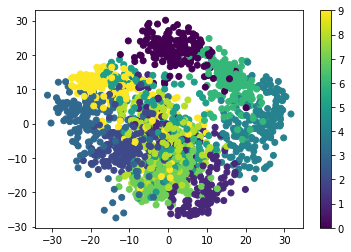

In [12]:
plt.scatter(Xproj[:, 0], Xproj[:, 1], c=y)
plt.colorbar();

This gives us an idea of the relationship between the digits. Essentially, we have found the optimal rotation in 64-dimensional space that allows us to see the layout of the digits, **without reference** to the labels.

But how much information have we thrown away?  We can figure this out by looking at the variance:

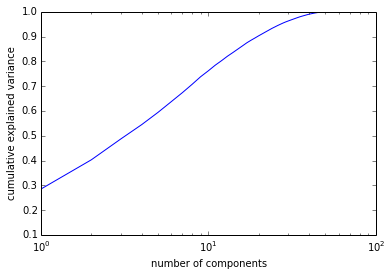

In [10]:
pca = PCA(64).fit(X)
plt.semilogx(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

Here we see that our two-dimensional projection loses a lot of information (as measured by the explained variance) and that we'd need about 20 components to retain 90% of the variance.  Looking at this plot for a high-dimensional dataset can help you understand the level of redundancy present in multiple observations.

Note that scikit-learn contains many other unsupervised dimensionality reduction routines: some you might wish to try are
Other dimensionality reduction techniques which are useful to know about:

- [sklearn.decomposition.PCA](http://scikit-learn.org/0.13/modules/generated/sklearn.decomposition.PCA.html): 
   Principal Component Analysis
- [sklearn.decomposition.RandomizedPCA](http://scikit-learn.org/0.13/modules/generated/sklearn.decomposition.RandomizedPCA.html):
   fast non-exact PCA implementation based on a randomized algorithm
- [sklearn.decomposition.SparsePCA](http://scikit-learn.org/0.13/modules/generated/sklearn.decomposition.SparsePCA.html):
   PCA variant including L1 penalty for sparsity
- [sklearn.decomposition.FastICA](http://scikit-learn.org/0.13/modules/generated/sklearn.decomposition.FastICA.html):
   Independent Component Analysis
- [sklearn.decomposition.NMF](http://scikit-learn.org/0.13/modules/generated/sklearn.decomposition.NMF.html):
   non-negative matrix factorization
- [sklearn.manifold.LocallyLinearEmbedding](http://scikit-learn.org/0.13/modules/generated/sklearn.manifold.LocallyLinearEmbedding.html):
   nonlinear manifold learning technique based on local neighborhood geometry
- [sklearn.manifold.IsoMap](http://scikit-learn.org/0.13/modules/generated/sklearn.manifold.Isomap.html):
   nonlinear manifold learning technique based on a sparse graph algorithm

## K Means

K Means is an algorithm for **unsupervised clustering**: that is, finding clusters in data based on the data attributes alone (not the labels).

K Means is a relatively easy-to-understand algorithm.  It searches for cluster centers which are the mean of the points within them, such that every point is closest to the cluster center it is assigned to.

Let's look at how KMeans operates on the simple clusters we looked at previously. To emphasize that this is unsupervised, we'll not plot the colors of the clusters:

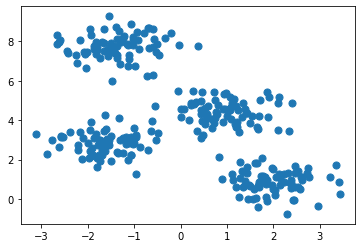

In [15]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=300, centers=4,
                  random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], s=50);

By eye, it is relatively easy to pick out the four clusters. If you were to perform an exhaustive search for the different segmentations of the data, however, the search space would be exponential in the number of points. Fortunately, there is a well-known *Expectation Maximization (EM)* procedure which scikit-learn implements, so that KMeans can be solved relatively quickly.

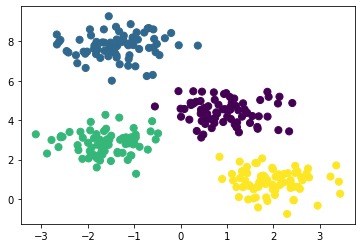

In [16]:
from sklearn.cluster import KMeans
est = KMeans(4)  # 4 clusters
est.fit(X)
y_kmeans = est.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50);

The algorithm identifies the four clusters of points in a manner very similar to what we would do by eye!

### Application of KMeans to Digits

For a closer-to-real-world example, let's again take a look at the digits data. Here we'll use KMeans to automatically cluster the data in 64 dimensions, and then look at the cluster centers to see what the algorithm has found.

In [74]:
est = KMeans(n_clusters=10)
clusters = est.fit_predict(digits.data)
est.cluster_centers_.shape

(10, 64)

In [67]:
clusters

array([1, 3, 3, ..., 3, 8, 8], dtype=int32)

We see ten clusters in 64 dimensions. Let's visualize each of these cluster centers to see what they represent:

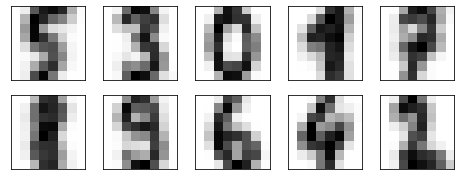

In [18]:
fig = plt.figure(figsize=(8, 3))
for i in range(10):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    ax.imshow(est.cluster_centers_[i].reshape((8, 8)), cmap=plt.cm.binary)

We see that *even without the labels*, KMeans is able to find clusters whose means are recognizable digits (with apologies to the number 8).

For good measure, let's use our PCA visualization and look at the true cluster labels and K-means cluster labels:

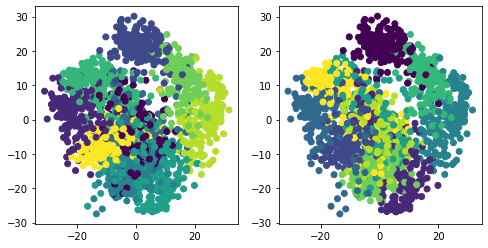

In [20]:
X = PCA(2).fit_transform(digits.data)

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].scatter(X[:, 0], X[:, 1], c=clusters)
ax[1].scatter(X[:, 0], X[:, 1], c=digits.target);

Though the colors are permuted, we see that in general (at least in a straightforward by-eye comparison) the KMeans clusters tend to reflect the true clustering.

## Exercise: KMeans for Color Compression

One interesting application of clustering is in color image compression. For example, imagine you have an image with millions of colors. In most images, a large number of the colors will be unused, and conversely a large number of pixels will have similar or identical colors.

Scikit-learn has a number of images that you can play with, accessed through the datasets module. For example:

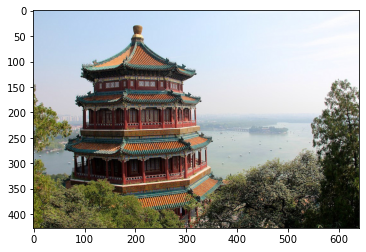

In [21]:
from sklearn.datasets import load_sample_image
china = load_sample_image("china.jpg")
plt.imshow(china);

The image itself is stored in a 3-dimensional array, of size ``(height, width, RGB)``:

In [22]:
china.shape

(427, 640, 3)

We can envision this image as a cloud of points in a 3-dimensional color space. We'll rescale the colors so they lie between 0 and 1, then reshape the array to be a typical scikit-learn input:

In [23]:
X = (china / 255.0).reshape(-1, 3)
print(X.shape)

(273280, 3)


We now have 273,280 points in 3 dimensions.  Your task is to use KMeans to compress the $256^3$ colors into a smaller number (say, 64 colors). Basically, you want to find $N_{color}$ clusters in the data, and create a new image where the true input color is replaced by the color of the closest cluster.

Your goal is to fill-in the following function:

(68480, 3)

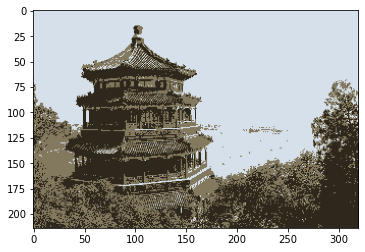

In [184]:
def compress_image(image, n_colors):
    """Compress an image

    Parameters
    ==========
    image : numpy array
        array of shape (height, width, 3) with values between 0 and 1
    n_colors : integer
        the number of colors in the final compressed image
        (i.e. the number of KMeans clusters to fit).
        
    Returns
    =======
    new_image : numpy array
        array representing the new image, compressed via KMeans clustering.
        It has the same shape as the input image, but contains only
        ``n_colors`` distinct colors.
    """
    X = (image / 255.0).reshape(-1, 3)
    new_image = image.copy()
    
    #------------
    cl = KMeans(n_clusters=n_colors)
    y_pred = cl.fit_predict(X)
    #new_image = (255 * new_image).astype(np.uint8)

    new_color =cl.cluster_centers_
    new_image = [new_color[i] for i in y_pred]
    plt.imshow(np.reshape(new_image, np.shape(image) ))




    #plt.imshow(y_pred.reshape(np.shape(image)[0],np.shape(image)[1]))


    #------------
    # if you convert back to integer, make sure it's the correct type!
    # i.e. new_image = (255 * new_image).astype(np.uint8)
    return new_image

# create and plot the new image
new_image = compress_image(china[::2,::2], 3)
np.shape(new_image)
#plt.imshow(new_image);

How does the color fidelity compare to the original?

Hint: because the calculation takes a long time, you may wish to test it on only a subset of the image. For example,
```
new_image = compress_image(china[::5, ::5], 64)
```